In [1]:
import urllib
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
import zipfile
from pathlib import Path
import pandas as pd

from torch.utils.data import DataLoader, Dataset

from helper import *
from knowledge_transfer import load_weights_into_gpt
from gpt_download import download_and_load_gpt2
from model import GPTModel
from tqdm import tqdm


In [2]:
zip_path = "sms_spam_collection.zip"
extract_path = "sms_spam_collection"
data_fite_path = Path(extract_path) / "SMSSpamCollection.tsv"


if not os.path.exists("sms_spam_collection/SMSSpamCollection.tsv"):
    url = "https://archive.ics.uci.edu/static/public/228/sms+spam+collection.zip"
    

    with urllib.request.urlopen(url) as response:
        with open (zip_path, "wb") as out_file:
            out_file.write(response.read())
    with zipfile.ZipFile(zip_path, "r") as f:
        f.extractall(extract_path)

    original_file_path = Path(extract_path) / "SMSSpamCollection"
    os.rename(original_file_path, data_fite_path)

    os.remove(zip_path)
    print("file downloaded just now")
else: print("file already downloaded")

file already downloaded


In [3]:
df = pd.read_csv(data_fite_path, sep = "\t", header = None, names = ["Label", "Text"])
df

,Label,Text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [4]:
df["Label"].value_counts()

Label
ham     4825
spam     747
Name: count, dtype: int64

In [5]:
int(df["Label"].value_counts().spam)

747

In [6]:
ham_subset = df[df["Label"] == "ham"].sample(int(df["Label"].value_counts().spam))
balanced_df = pd.concat((ham_subset, df[df["Label"] == "spam"])).reset_index(drop = True)
balanced_df["Label"].value_counts()

Label
ham     747
spam    747
Name: count, dtype: int64

In [7]:
balanced_df

,Label,Text
0,ham,Are you not around or just still asleep? :V
1,ham,THANX 4 PUTTIN DA FONE DOWN ON ME!!
2,ham,Hi dear we saw dear. We both are happy. Where ...
3,ham,R u in this continent?
4,ham,I'm very happy for you babe ! Woo hoo party on...
...,...,...
1489,spam,Want explicit SEX in 30 secs? Ring 02073162414...
1490,spam,ASKED 3MOBILE IF 0870 CHATLINES INCLU IN FREE ...
1491,spam,Had your contract mobile 11 Mnths? Latest Moto...
1492,spam,REMINDER FROM O2: To get 2.50 pounds free call...


In [8]:
# ham = 0
# spam = 0

In [9]:
balanced_df["Label"] = balanced_df["Label"].map({"ham": 0, "spam": 1})
balanced_df

,Label,Text
0,0,Are you not around or just still asleep? :V
1,0,THANX 4 PUTTIN DA FONE DOWN ON ME!!
2,0,Hi dear we saw dear. We both are happy. Where ...
3,0,R u in this continent?
4,0,I'm very happy for you babe ! Woo hoo party on...
...,...,...
1489,1,Want explicit SEX in 30 secs? Ring 02073162414...
1490,1,ASKED 3MOBILE IF 0870 CHATLINES INCLU IN FREE ...
1491,1,Had your contract mobile 11 Mnths? Latest Moto...
1492,1,REMINDER FROM O2: To get 2.50 pounds free call...


In [10]:
def random_split(df :pd.DataFrame, train_split, val_split):
    assert (train_split > 0 )and (train_split < 1)
    assert (val_split > 0) and (val_split < 1)

    shuffled_df = df.sample(frac=1, random_state=42).reset_index(drop=True)

    n = len(df)
    train_end = int(train_split * n)
    val_end = train_end + int(val_split * n)

    train_df = shuffled_df.iloc[:train_end]
    val_df   = shuffled_df.iloc[train_end:val_end]
    test_df  = shuffled_df.iloc[val_end:]

    return train_df, val_df, test_df


train_df, val_df, test_df = random_split(balanced_df, 0.7, 0.1)
len(train_df), len(val_df), len(test_df)

(1045, 149, 300)

In [11]:
train_df.to_csv("train.csv", index = None)
val_df.to_csv("val.csv", index = None)
test_df.to_csv("test.csv", index = None)

In [12]:
import tiktoken

tokenizer = tiktoken.get_encoding("gpt2")
tokenizer.decode([50256])

'<|endoftext|>'

In [13]:
class SpamDataset(Dataset):
    def __init__(self, csv_file, tokenizer, max_length = None, pad_token = 50256):
        
        self.df = pd.read_csv(csv_file)
        self.encoded_text = [tokenizer.encode(text) for text in self.df["Text"]]

        if max_length is None:
            self.max_length = self._longest_encoded_length()
        else:
            self.max_length = max_length
            self.encoded_text = [encoded_text[:self.max_length] for encoded_text in self.encoded_text]

        # padding
        self.encoded_text = [
            encoded_text + [pad_token] * (self.max_length - len(encoded_text))
            for encoded_text in self.encoded_text
        ]
    
    def __getitem__(self, index):
        encoded = self.encoded_text[index]
        label = self.df.iloc[index]["Label"]

        return (
            torch.tensor(encoded, dtype=torch.long),
            torch.tensor(label, dtype=torch.long)
            )
    
    def __len__(self):
        return len(self.df)

    def _longest_encoded_length(self):
        return max(len(encoded_text) for encoded_text in self.encoded_text)


In [14]:
train_dataset = SpamDataset(
                    csv_file="train.csv",
                    tokenizer=tokenizer,
                )

val_dataset = SpamDataset(
                    csv_file="val.csv",
                    tokenizer=tokenizer,
                    max_length=train_dataset.max_length
                )

test_dataset = SpamDataset(
                    csv_file="test.csv",
                    tokenizer=tokenizer,
                    max_length=train_dataset.max_length
                )

train_dataset.max_length

120

In [15]:
num_workers = 0
batch_size = 8

# torch.manual_seed(123)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    drop_last=True,
)

val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False,
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False,
)

In [16]:
print("Train loader:")
for input_batch, target_batch in train_loader:
    pass

print("Input batch dimensions:", input_batch.shape)
print("Label batch dimensions", target_batch.shape)

Train loader:
Input batch dimensions: torch.Size([8, 120])
Label batch dimensions torch.Size([8])


In [17]:
input_batch.shape

torch.Size([8, 120])

In [18]:
target_batch

tensor([0, 0, 1, 0, 0, 0, 1, 0])

In [19]:
print(f"{len(train_loader)} training batches")
print(f"{len(val_loader)} validation batches")
print(f"{len(test_loader)} test batches")

130 training batches
19 validation batches
38 test batches


In [20]:

settings, params = download_and_load_gpt2(model_size="124M", models_dir="gpt2")



GPT_CONFIG_124M = {
    "vocab_size"     : tokenizer.n_vocab, # 50257
    "context_length" : 1024,                  # The maximum number of tokens the model can process at once
    "embedding_dim"  : 768,                   # The number of features used to represent each token 
    "n_heads"        : 12,
    "n_layers"       : 12,                    # How many transformer blocks
    "drop_rate"      : 0.1,
    "qkv_bias"       : False
}

model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

model_name = "gpt2-small (124M)"

NEW_CONFIG = GPT_CONFIG_124M.copy()
NEW_CONFIG.update(model_configs[model_name])
NEW_CONFIG.update({"context_length": 1024, "qkv_bias": True})

gpt = GPTModel(NEW_CONFIG)
device = "cpu"
load_weights_into_gpt(gpt, params)
gpt.to(device);

File already exists and is up-to-date: gpt2/124M/checkpoint
File already exists and is up-to-date: gpt2/124M/encoder.json
File already exists and is up-to-date: gpt2/124M/hparams.json
File already exists and is up-to-date: gpt2/124M/model.ckpt.data-00000-of-00001
File already exists and is up-to-date: gpt2/124M/model.ckpt.index
File already exists and is up-to-date: gpt2/124M/model.ckpt.meta
File already exists and is up-to-date: gpt2/124M/vocab.bpe


In [21]:
# torch.manual_seed(123)

token_ids = generate(
    model=gpt,
    tokens=text_to_token_ids("your hair is winter fire", tokenizer).to(device),
    max_new_tokens=100,
    context_size=NEW_CONFIG["context_length"],
    top_k=50,
    temperature=1.5,
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 your hair is winter fire.
Cancer, when left-hooked on the back of their penis
fans it and their hair, and then like all hair-on-your-head it'll explode in the fire from a
mesh. Not to be confused by the two, as I'm told they've really only given them the "two of y-too high. a fussy."


If it was you

There's too many things out there and I won't get it.


In [22]:
for params in gpt.parameters():
    params.requires_grad = False

for params in gpt.transformer_blocks[-1].parameters():
    params.requires_grad = True

for params in gpt.final_norm.parameters():
    params.requires_grad = True

num_classes = 2

gpt.out_head = torch.nn.Linear(in_features = 768, out_features = num_classes)
gpt.out_head

Linear(in_features=768, out_features=2, bias=True)

In [23]:
input_ids = tokenizer.encode("do you have time")
logits = gpt(torch.tensor(input_ids).unsqueeze(0))[:, -1, :]
logits

tensor([[-4.3902, -1.0732]], grad_fn=<SelectBackward0>)

In [24]:
label = torch.argmax(logits, dim = -1).item()
label

1

In [25]:
def calc_accuracy(data_loader, model, device, num_batches = None):
    model.eval()
    correct_preds, viewed_classes = 0, 0
    if num_batches:
        num_batches = min(num_batches, len(data_loader))
    else:
        num_batches = len(data_loader)
    
    for idx, (input_batch, target_batch) in enumerate(data_loader):
        if idx < num_batches:
            input_batch, target_batch = input_batch.to(device), target_batch.to(device)
            with torch.no_grad():
                logits = model(input_batch)[:, -1, :]
                pred_labels = torch.argmax(logits, dim = -1)

            correct_preds += (pred_labels == target_batch).sum().item()
            viewed_classes += input_batch.shape[0]
        else: break
        
    model.train()
    return correct_preds / viewed_classes

calc_accuracy(train_loader, gpt, "cpu", num_batches=2)

0.5

In [26]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)[:, -1, :]
    return torch.nn.functional.cross_entropy(logits, target_batch) # loss

def calc_loss_loader(dataloader, model, device, num_batches = None):
    if len(dataloader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(dataloader)
    else:
        num_batches = min(num_batches, len (dataloader))

    total_loss = 0
    for idx, (input_batch, target_batch) in enumerate(dataloader):
        if idx < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else: break
    return total_loss / num_batches

calc_loss_loader(train_loader, gpt, "cpu", num_batches = 10)

0.897229689359665

In [27]:
def train_simple(model      : torch.nn.Module,
                train_loader: DataLoader,
                val_loader  : DataLoader,
                optimizer   : torch.optim.Optimizer,
                num_epochs  : int,
                eval_freq   : int,
                eval_iter   : int,
                device      : str):
    
    train_losses, val_losses, train_accs, val_accs = [], [], [], []

    examples_seen, global_step = 0, -1

    for epoch in range(num_epochs):
        model.train()
        for input_batch, target_batch in tqdm(train_loader, total=len(train_loader)):
            optimizer.zero_grad()
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward()
            optimizer.step()

            examples_seen += input_batch.shape[0]
            global_step += 1

            if global_step % eval_freq == 0:
                model.eval()
                with torch.no_grad():
                    train_loss = calc_loss_loader(train_loader, model, device, num_batches = eval_iter)
                    val_loss = calc_loss_loader(val_loader, model, device, num_batches = eval_iter)

                train_losses.append(train_loss)
                val_losses.append(val_loss)
                model.train()

                print(f"Epoch: {epoch} | train loss: {train_loss:.3f} | val loss: {val_loss:.3f}")


        # after every batch calculate accuracy
        train_acc = calc_accuracy(train_loader, model, device, num_batches=eval_iter)
        val_acc   = calc_accuracy(val_loader, model, device, num_batches=eval_iter)

        print(f"Training accuracy: {train_acc*100:.2f}% | ", end="") 
        print(f"Validation accuracy: {val_acc*100:.2f}%")

        train_accs.append(train_acc)
        val_accs.append(val_acc)

    return train_losses, val_losses, train_accs, val_accs, examples_seen



In [28]:
settings, params = download_and_load_gpt2(model_size="124M", models_dir="gpt2")

GPT_CONFIG_124M = {
    "vocab_size"     : tokenizer.n_vocab, # 50257
    "context_length" : 1024,                  # The maximum number of tokens the model can process at once
    "embedding_dim"  : 768,                   # The number of features used to represent each token 
    "n_heads"        : 12,
    "n_layers"       : 12,                    # How many transformer blocks
    "drop_rate"      : 0.1,
    "qkv_bias"       : False
}

model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

model_name = "gpt2-small (124M)"

NEW_CONFIG = GPT_CONFIG_124M.copy()
NEW_CONFIG.update(model_configs[model_name])
NEW_CONFIG.update({"context_length": 1024, "qkv_bias": True})

model = GPTModel(NEW_CONFIG)
device = "cpu"
load_weights_into_gpt(model, params)
model.to(device)



File already exists and is up-to-date: gpt2/124M/checkpoint
File already exists and is up-to-date: gpt2/124M/encoder.json
File already exists and is up-to-date: gpt2/124M/hparams.json
File already exists and is up-to-date: gpt2/124M/model.ckpt.data-00000-of-00001
File already exists and is up-to-date: gpt2/124M/model.ckpt.index
File already exists and is up-to-date: gpt2/124M/model.ckpt.meta
File already exists and is up-to-date: gpt2/124M/vocab.bpe


GPTModel(
  (token_embedding): Embedding(50257, 768)
  (position_embedding): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (transformer_blocks): Sequential(
    (0): TransformerBlock(
      (attn): MutliHeadAttention(
        (W_keys): Linear(in_features=768, out_features=768, bias=True)
        (W_queries): Linear(in_features=768, out_features=768, bias=True)
        (W_values): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): Feedforward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (dropout_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (attn): MutliHeadAttention(
   

In [29]:
for params in model.parameters():
    params.requires_grad = False

for params in model.transformer_blocks[-1].parameters():
    params.requires_grad = True

for params in model.final_norm.parameters():
    params.requires_grad = True

num_classes = 2

model.out_head = torch.nn.Linear(in_features = 768, out_features = num_classes)

for p in model.out_head.parameters():
    p.requires_grad = True

model.out_head

Linear(in_features=768, out_features=2, bias=True)

In [30]:
torch.manual_seed(123)

num_epochs = 2

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=0.1)
train_losses, val_losses, train_accs, val_accs, examples_seen = train_simple(model       = model,
                                                                            train_loader = train_loader,
                                                                            val_loader   = val_loader,
                                                                            optimizer    = optimizer,
                                                                            num_epochs   = num_epochs,
                                                                            eval_freq    = 50,
                                                                            eval_iter    = 5,
                                                                            device       = "cpu")

  1%|          | 1/130 [00:05<10:49,  5.03s/it]

Epoch: 0 | train loss: 5.909 | val loss: 5.910


 39%|███▉      | 51/130 [00:39<02:23,  1.82s/it]

Epoch: 0 | train loss: 1.260 | val loss: 1.024


 78%|███████▊  | 101/130 [01:12<00:52,  1.83s/it]

Epoch: 0 | train loss: 0.831 | val loss: 0.760


100%|██████████| 130/130 [01:29<00:00,  1.45it/s]


Training accuracy: 55.00% | Validation accuracy: 60.00%


 16%|█▌        | 21/130 [00:16<03:17,  1.81s/it]

Epoch: 1 | train loss: 0.568 | val loss: 0.660


 55%|█████▍    | 71/130 [00:49<01:47,  1.82s/it]

Epoch: 1 | train loss: 0.960 | val loss: 0.688


 93%|█████████▎| 121/130 [01:22<00:16,  1.81s/it]

Epoch: 1 | train loss: 0.548 | val loss: 0.575


100%|██████████| 130/130 [01:28<00:00,  1.47it/s]


Training accuracy: 70.00% | Validation accuracy: 77.50%


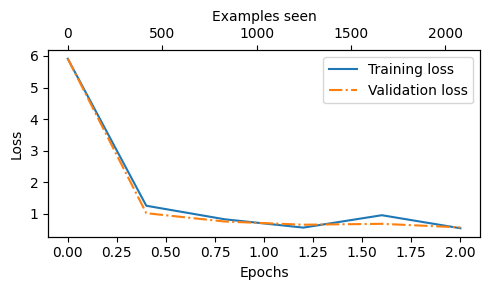

In [31]:
def plot_values(epochs_seen, examples_seen, train_values, val_values, label="loss"):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    # Plot training and validation loss against epochs
    ax1.plot(epochs_seen, train_values, label=f"Training {label}")
    ax1.plot(epochs_seen, val_values, linestyle="-.", label=f"Validation {label}")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel(label.capitalize())
    ax1.legend()

    # Create a second x-axis for examples seen
    ax2 = ax1.twiny()  # Create a second x-axis that shares the same y-axis
    ax2.plot(examples_seen, train_values, alpha=0)  # Invisible plot for aligning ticks
    ax2.set_xlabel("Examples seen")

    fig.tight_layout()  # Adjust layout to make room
    plt.savefig(f"{label}-plot.pdf")
    plt.show()

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_losses))

plot_values(epochs_tensor, examples_seen_tensor, train_losses, val_losses)

In [69]:
def spam_or_not(model, text, pad_token, max_len):
    tokens = tokenizer.encode(text)
    input_ids = tokens + [pad_token] * abs(len(tokens) - max_len)
    input_tensor = torch.tensor(input_ids).unsqueeze(0)
    with torch.no_grad():
        logits = model(input_tensor)[:, -1, :]  # Logits of the last output token
        predicted_label = torch.argmax(logits, dim=-1).item()

    return "spam" if predicted_label == 1 else "not spam"

In [78]:
t1 = "hello, how are you"
pad_token = 50256
max_len = train_dataset.max_length

spam_or_not(model, t1, pad_token = 50256, max_len = max_len)

'not spam'

In [99]:
t2 = (
    "Hey, just wanted to check if we're still on"
    " for dinner tonight? Let me know!"
)

spam_or_not(model, t2, pad_token = 50256, max_len = max_len)

'not spam'

In [101]:
t3 = (
    "You are a winner you have been specially"
    " selected to receive $1000 cash or a $2000 award."
)

spam_or_not(model, t3, pad_token = 50256, max_len = max_len)

'spam'